In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import *
import time

%matplotlib inline

In [2]:
df = pd.read_csv('df.csv')

In [3]:
def split_data(df, indepv):
    '''
    Split the data into training and testing set
    
    And save them to run try different models
    '''
    y = df['re-entry']
    x = df[indepv]
    # get train/test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=1234)
    
    return x_train, x_test, y_train, y_test

In [4]:
clfs = {'RF': RandomForestClassifier(),
    'Boost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)),
    'Logit': LogisticRegression(),
    'SVM': SVC(probability=True, random_state=0),
    'Tree': DecisionTreeClassifier(),
    'Bag': BaggingClassifier(),
    'KNN': KNeighborsClassifier() 
    }
    
small_grid = {'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'Boost': {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000]},
    'Logit': {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10]},
    'SVM' :{'C' :[0.01,0.1,1,10],'kernel':['linear']},
    'Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [5,10,20,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5]},
    'Bag':{'n_estimators':[1,10,20,50], 'max_samples':[5,10], 'max_features': [5,10]},
    'KNN' :{'n_neighbors': [1,10,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
    }


def generate_binary_at_k(y_scores, k):
    '''
    Set first k% as 1, the rest as 0.
    '''
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary


def scores_at_k(y_true, y_scores, k):
    '''
    For a given level of k, calculate corresponding
    precision, recall, and f1 scores.
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = precision_score(y_true, preds_at_k)
    recall = recall_score(y_true, preds_at_k)
    f1 = f1_score(y_true, preds_at_k)
    return precision, recall, f1


def plot(y_test, y_pred_probs, model, para = None):

    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for {} model: AUC={:.2f} \n with parameters: {}'.\
                        format(model, average_precision_score(y_test, y_pred_probs), para))
    plt.show()
    

def clf_loop(models, x_train, x_test, y_train, y_test):
    '''
    Run model with given params on x and y
    and print out the scores for comparison
    '''
    results_df = pd.DataFrame(columns=('model_type', 'parameters', 'accuracy','auc-roc', 'auc-pr', 'time', 'precision,recall,f1 at_5',
     'precision,recall,f1 at_10', 'precision,recall,f1 at_20'))
    for index, clf in enumerate([clfs[x] for x in models]):
        model_params = small_grid[models[index]]
        for p in ParameterGrid(model_params):
            try:
                start = time.time()
                clf.set_params(**p)
                y_pred_probs = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
                accuracy = clf.score(x_test, y_test)
                end = time.time()
                #Zip, unzip to ensure corresponding order
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))

                results_df.loc[len(results_df)] = [models[index], p, accuracy,
                                                    roc_auc_score(y_test, y_pred_probs),
                                                    average_precision_score(y_test, y_pred_probs), end-start,                                                     
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                    scores_at_k(y_test_sorted,y_pred_probs_sorted,20.0)]

                plot(y_test, y_pred_probs, models[index], p)
                
            except IndexError as e:
                print(e)
                continue
    return results_df

In [5]:
#4 GenerateFeatures/Predictors: discretize a continuous variable 
def discrete_val(df, cols, bins=4):
    '''
    Helper function to discrete the continueous variable in dataframe into 4 bins
    This function will return dictionary mapping column name to the bin values
    '''
    for col in cols:
        new = col+'_binned'
        df[new] = pd.cut(df[col], bins, include_lowest=True, labels = range(0,bins))
        df.drop([col], inplace=True, axis=1)
    return df

In [6]:
#generate dummy variable for specific column
def getting_dummy(df, col):
    '''
    Helper function to create dummy variables in dataframe for specific column
    This function will return dataframe
    '''
    dummies = pd.get_dummies(df[col]).rename(columns=lambda x: str(col)+ str(x))
    df = pd.concat([df, dummies], axis=1)
    df.drop([col], inplace=True, axis=1)
    return df

In [7]:
dummy_vals = ['bail_type', 'gender', 'race', 'arresting_agency']

In [8]:
for dummy in dummy_vals:
    df = getting_dummy(df, dummy)

In [9]:
indepv = ['bail_amt', 'booking_days', 'treatment_days', 'mental_health', 'age',
 'bail_typeCA','bail_typeGPS','bail_typeORCD','bail_typePR','bail_typeSUR',
 'genderF','genderM',
 'raceA','raceB','raceI','raceW',
 'arresting_agencyFAIRWAY P.D.','arresting_agencyGARDNER P.D.',
 'arresting_agencyJOHNSON COUNTY PARK PATROL',
 "arresting_agencyJOHNSON COUNTY SHERIFF'S DEPARTMENT",
 'arresting_agencyKANSAS HIGHWAY PATROL',
 'arresting_agencyLAKE QUIVIRA P.D.',
 'arresting_agencyLEAWOOD P.D.',
 'arresting_agencyLENEXA P.D.',
 'arresting_agencyMERRIAM P.D.',
 'arresting_agencyMISSION P.D.',
 'arresting_agencyOLATHE P.D.',
 'arresting_agencyOTHER AGENCY',
 'arresting_agencyOVERLAND PARK P.D.',
 'arresting_agencyPRAIRIE VILLAGE P.D.',
 'arresting_agencyROELAND PARK P.D.',
 'arresting_agencySHAWNEE P.D.',
 'arresting_agencySPRING HILL P.D.',
 'arresting_agencyWESTWOOD P.D.']

In [10]:
x_train, x_test, y_train, y_test = split_data(df, indepv)

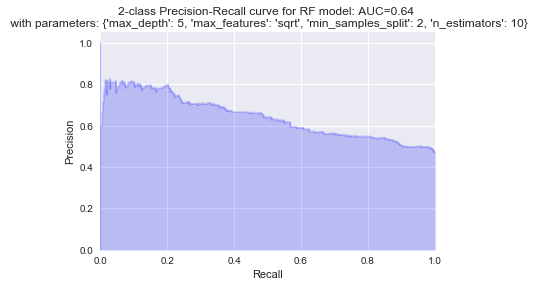

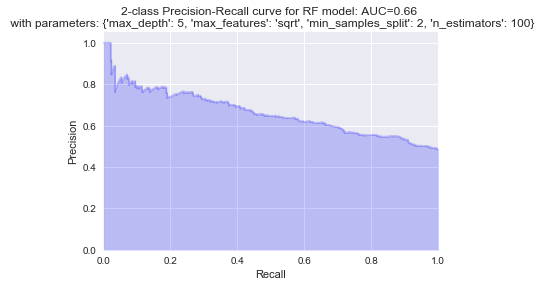

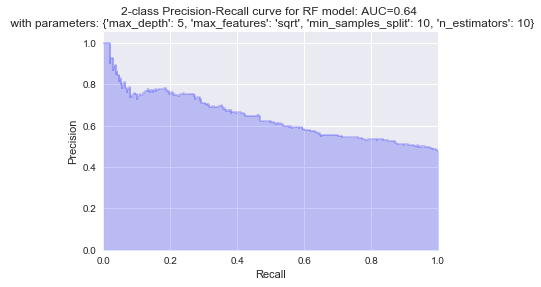

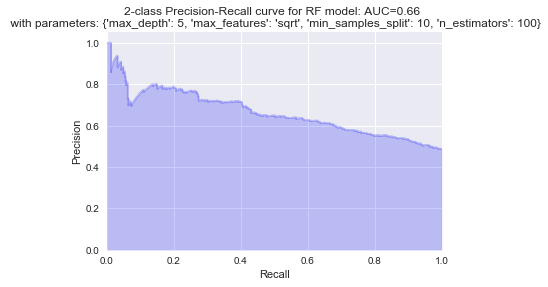

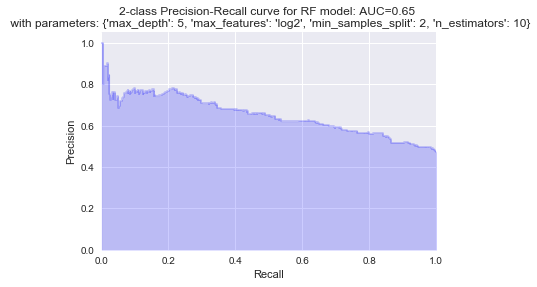

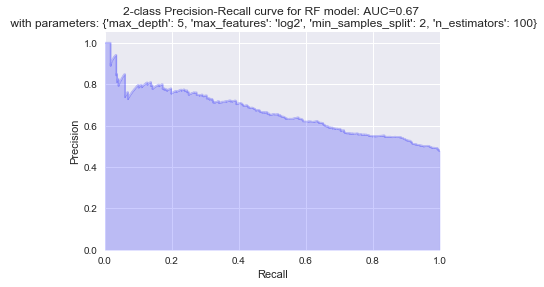

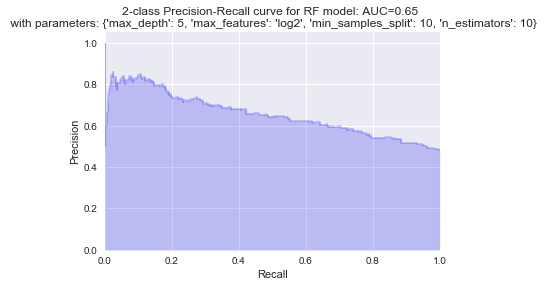

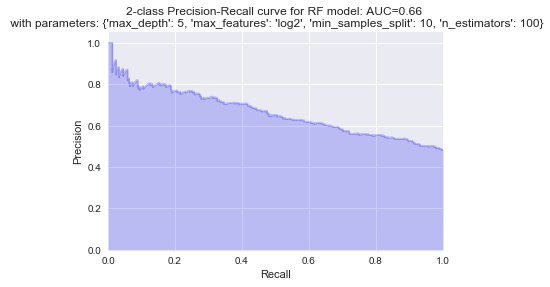

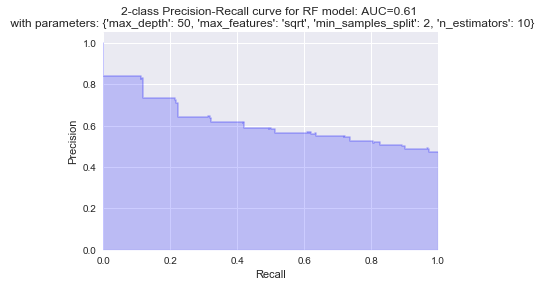

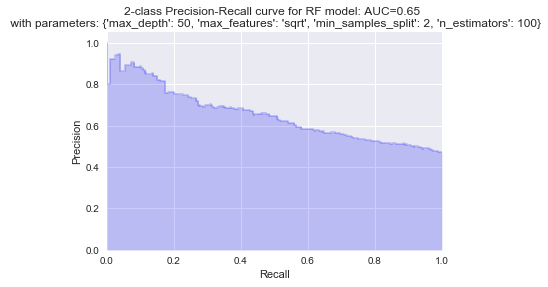

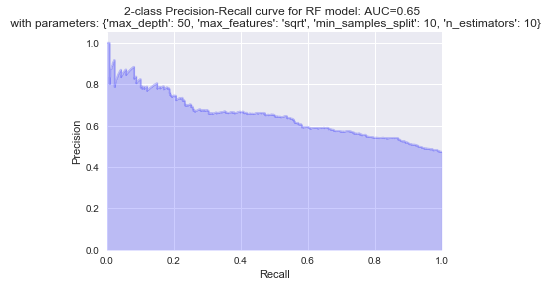

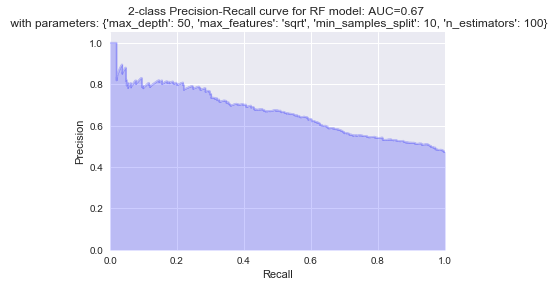

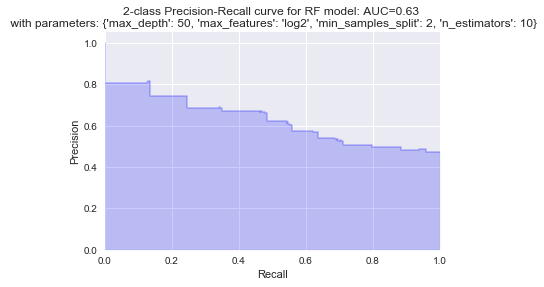

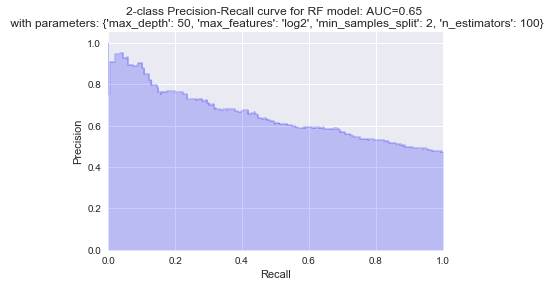

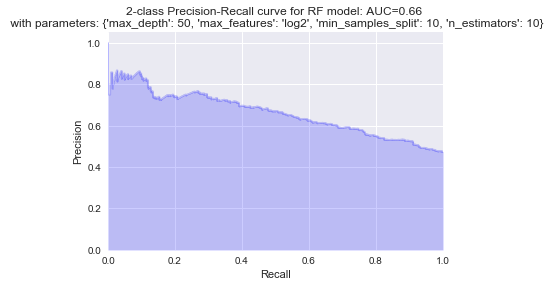

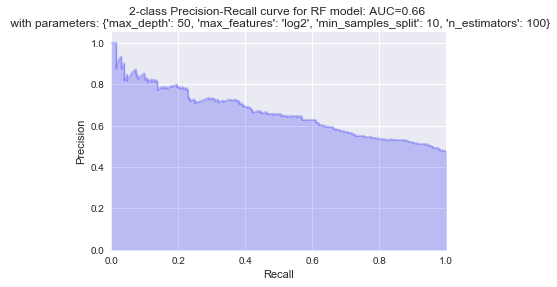

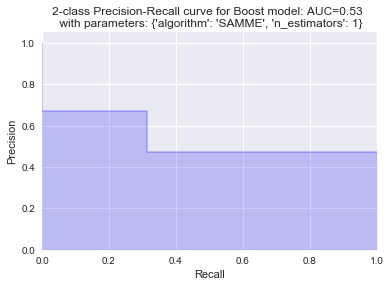

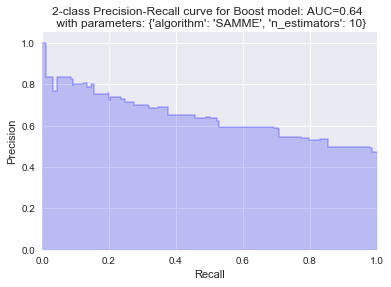

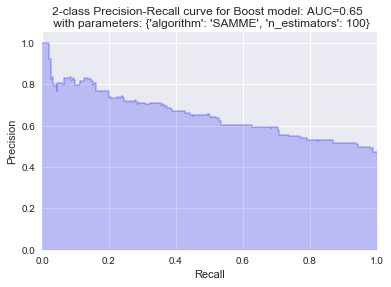

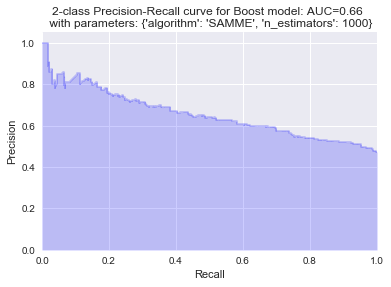

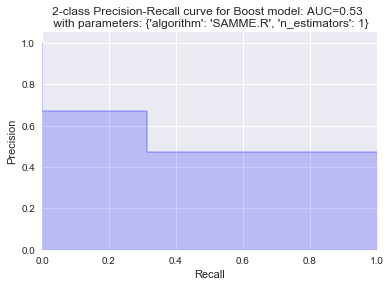

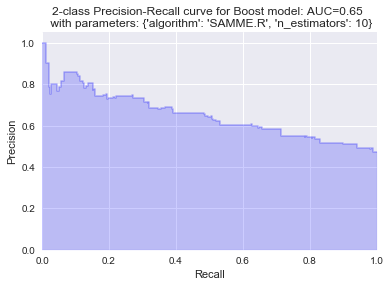

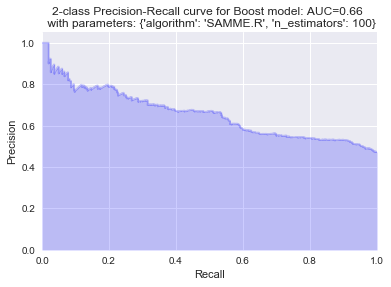

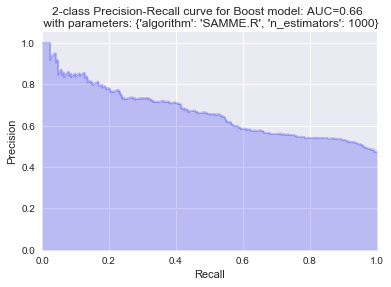

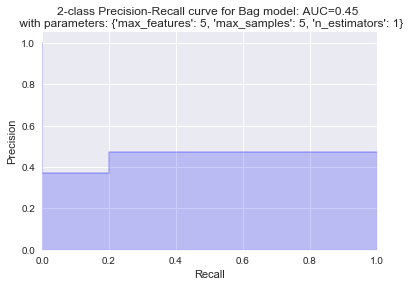

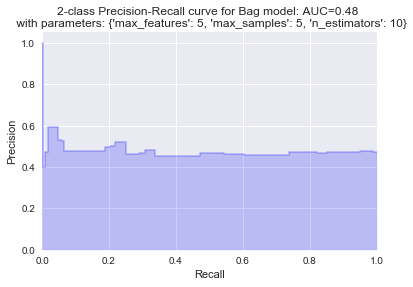

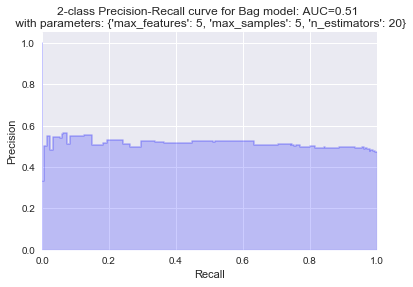

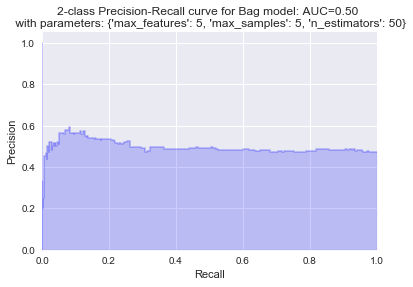

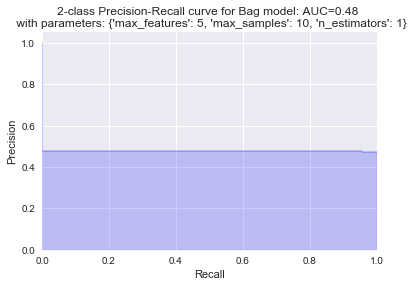

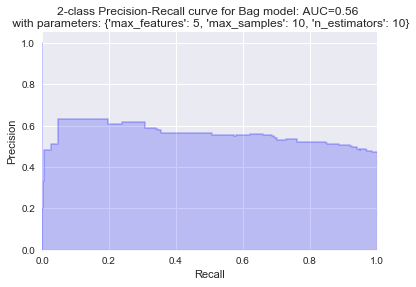

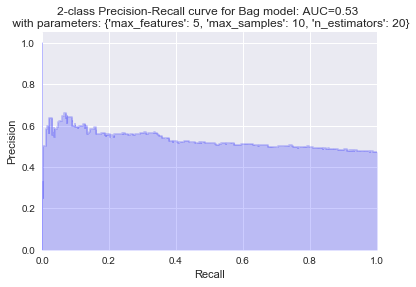

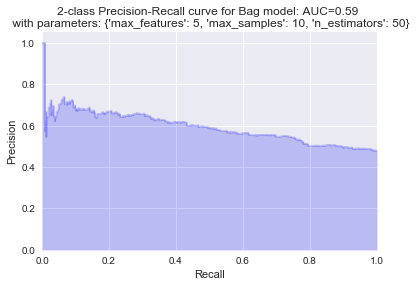

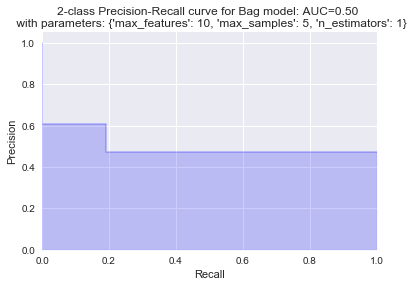

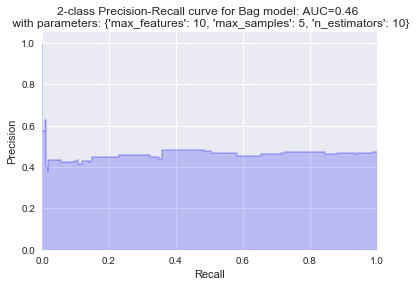

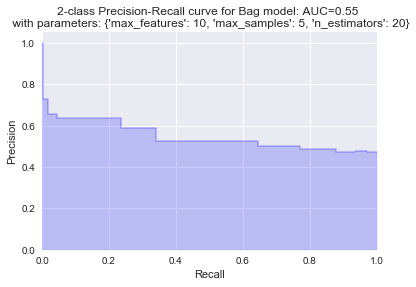

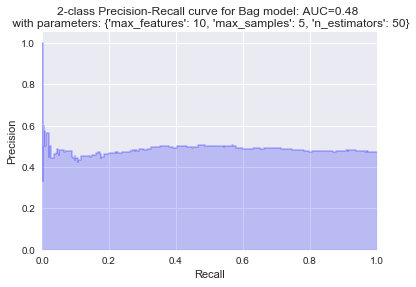

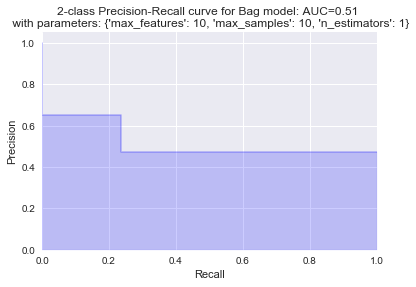

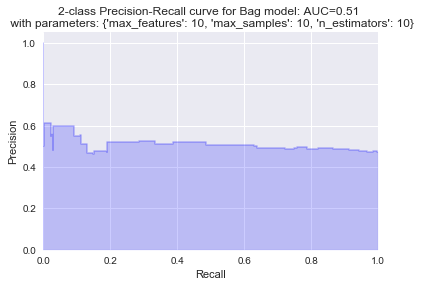

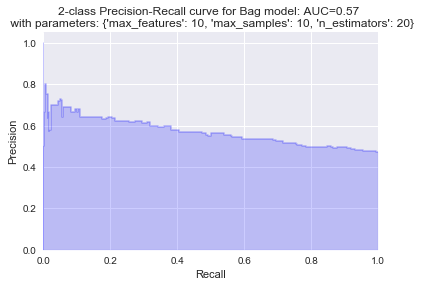

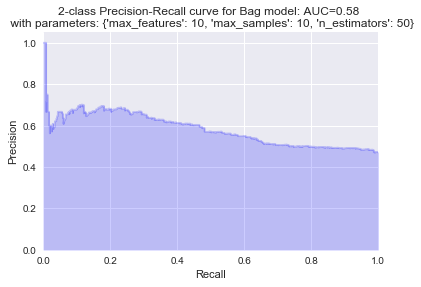

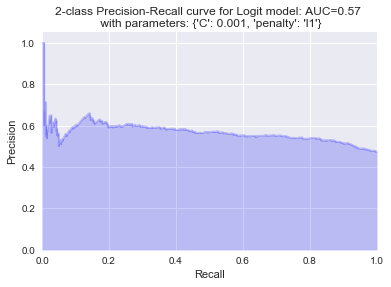

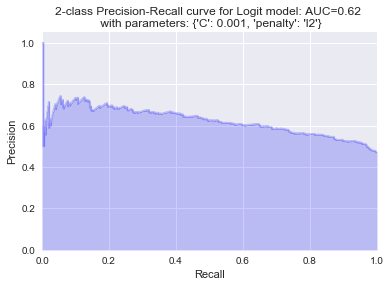

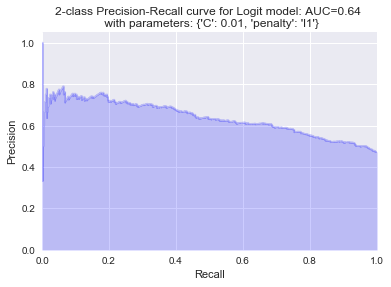

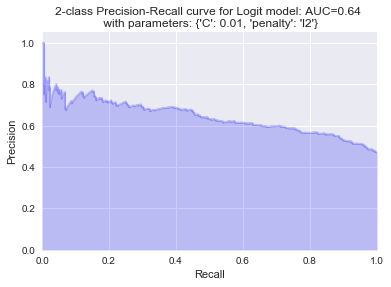

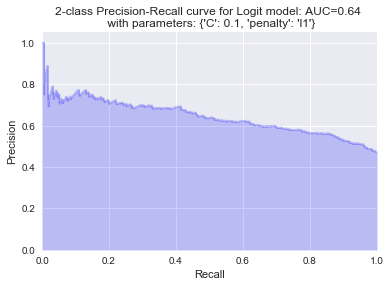

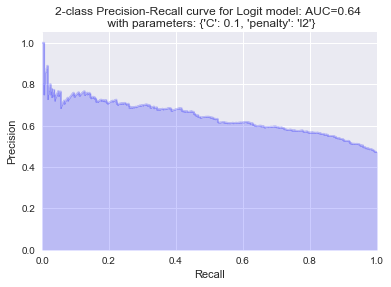

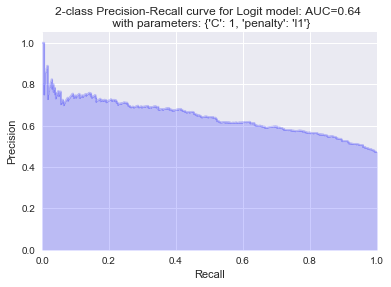

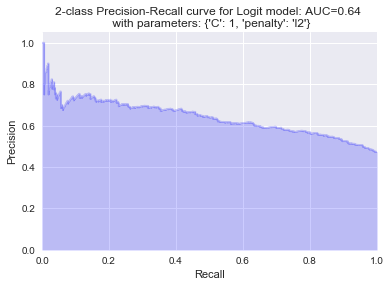

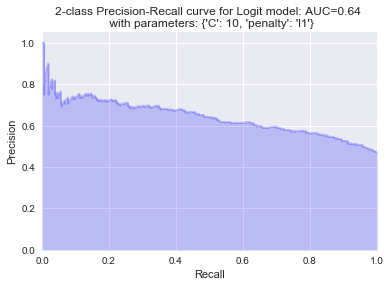

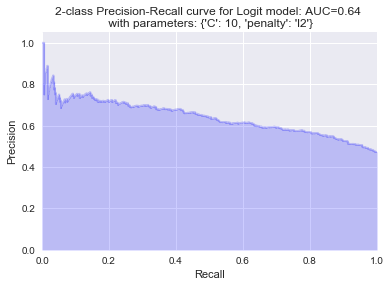

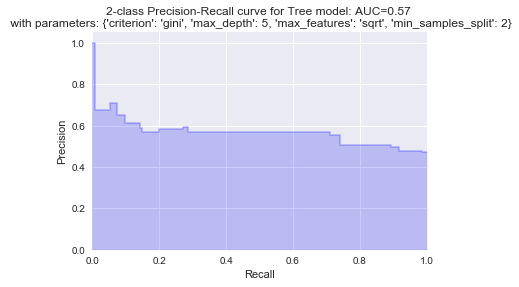

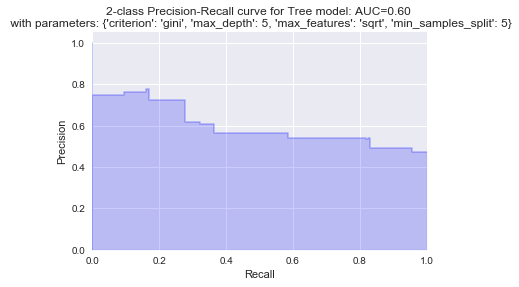

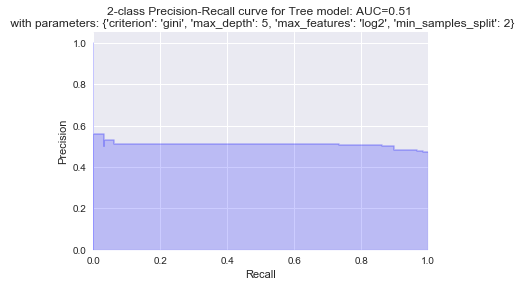

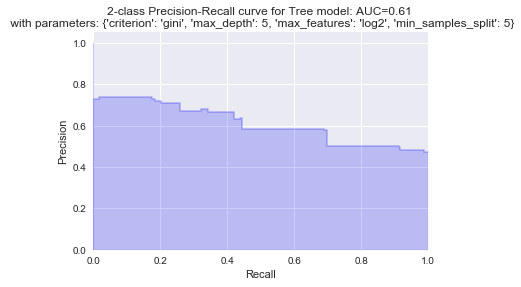

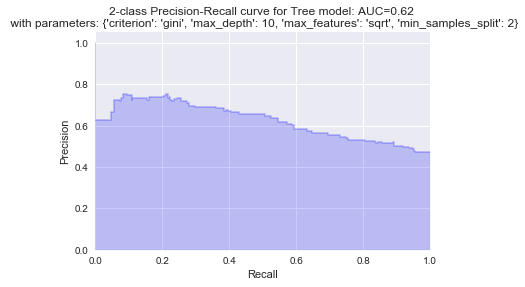

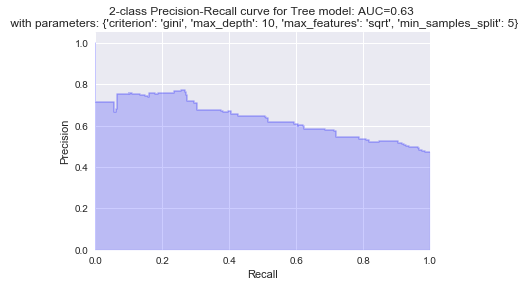

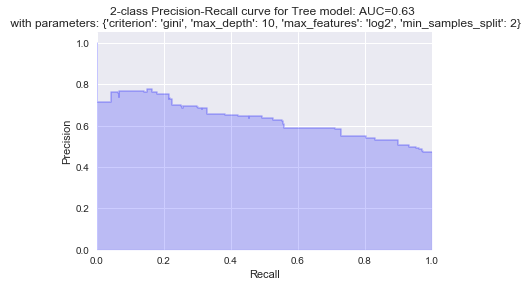

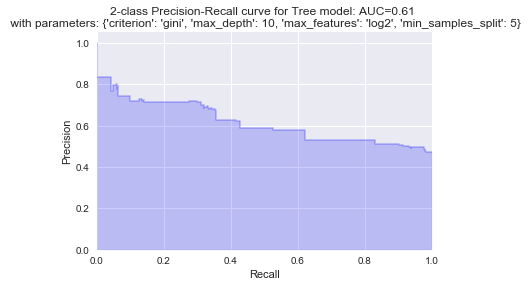

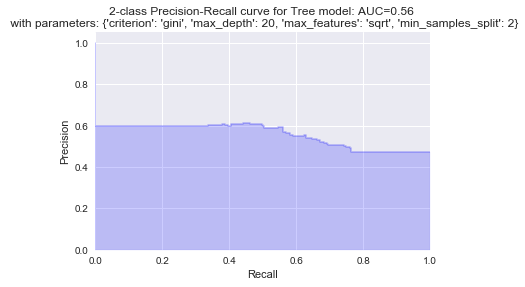

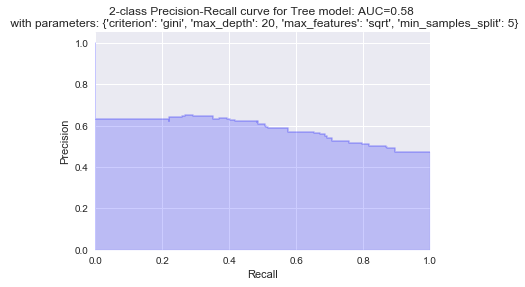

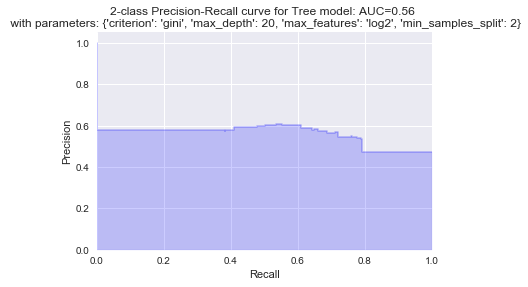

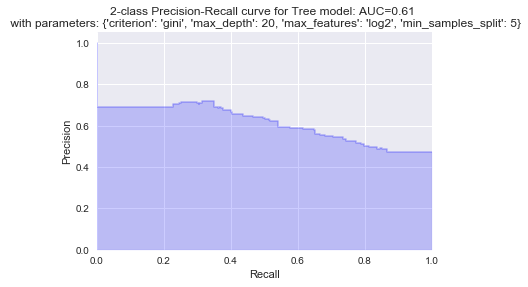

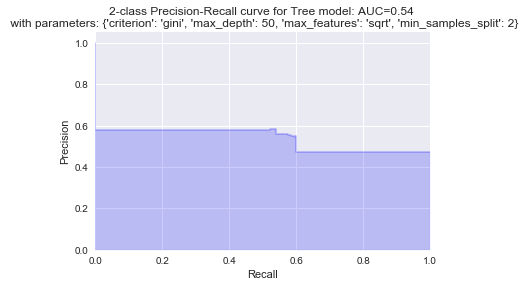

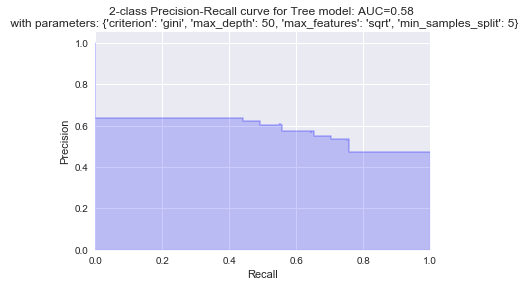

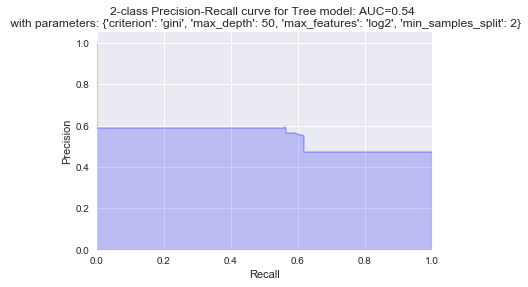

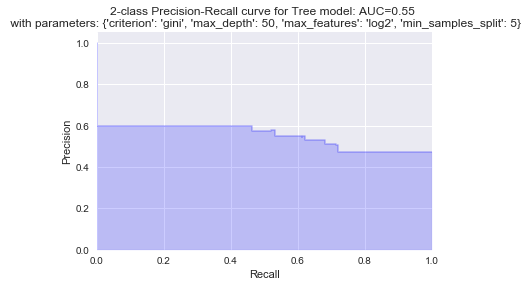

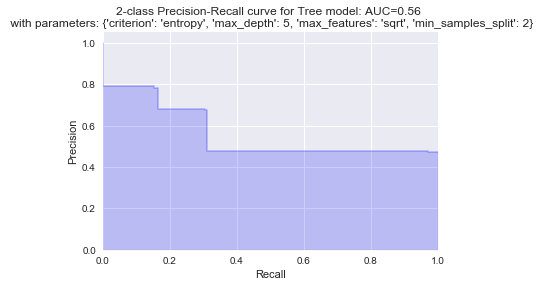

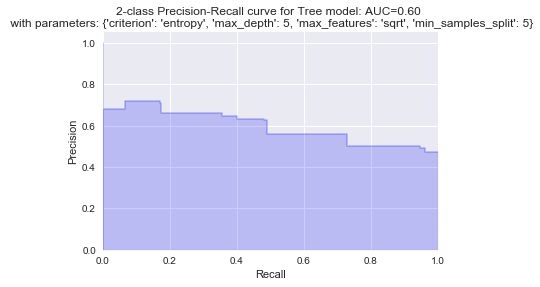

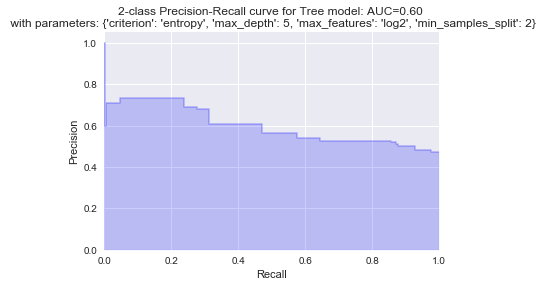

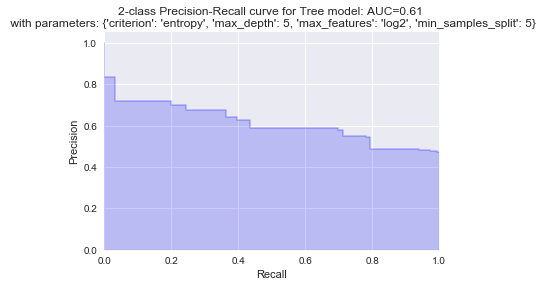

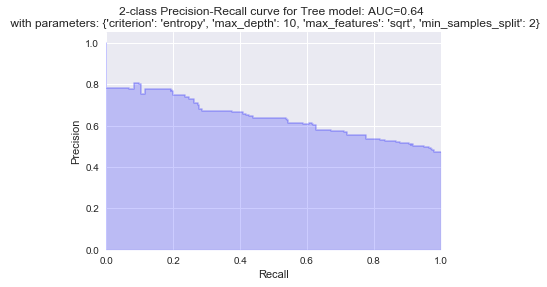

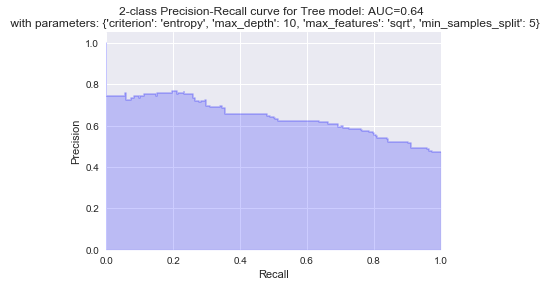

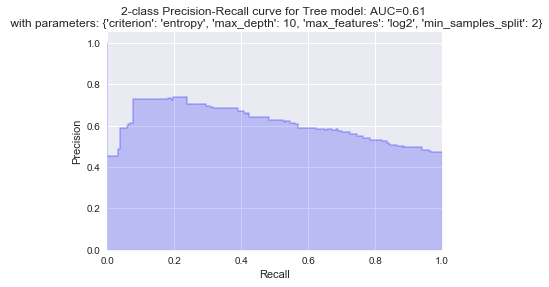

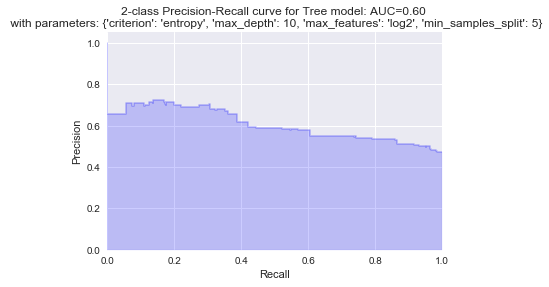

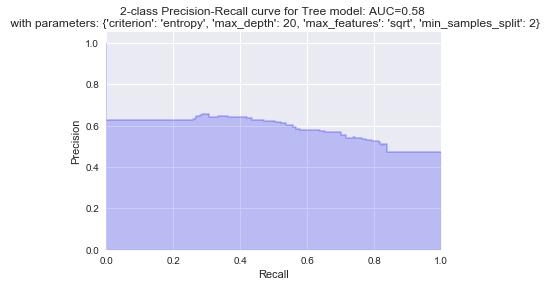

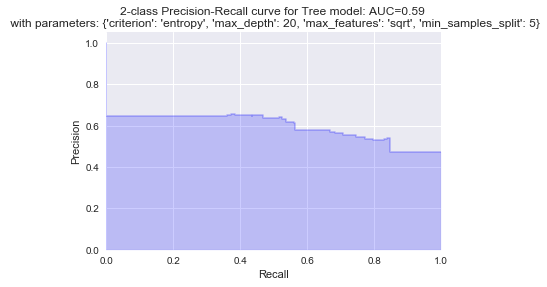

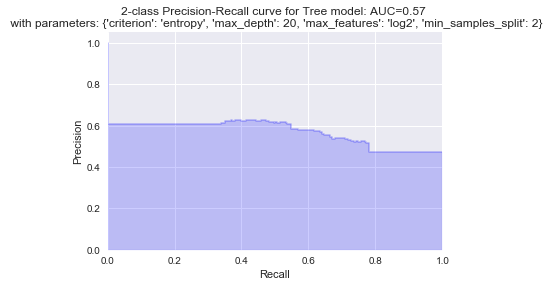

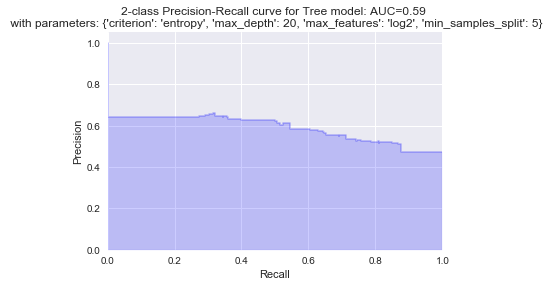

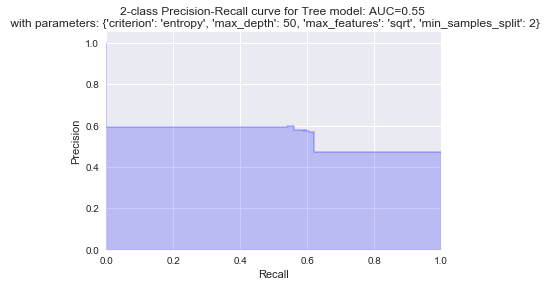

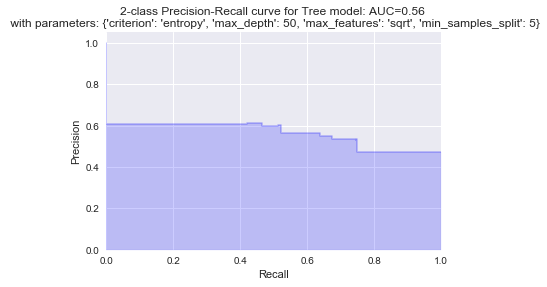

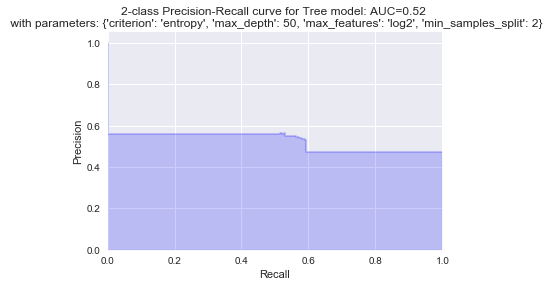

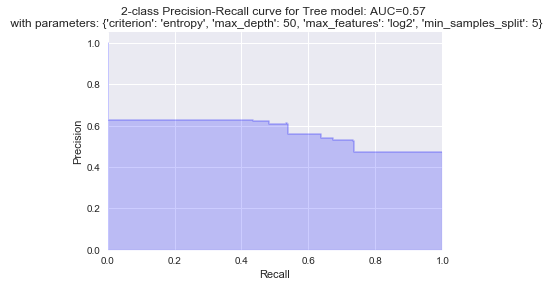

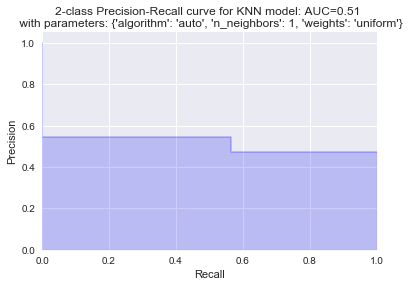

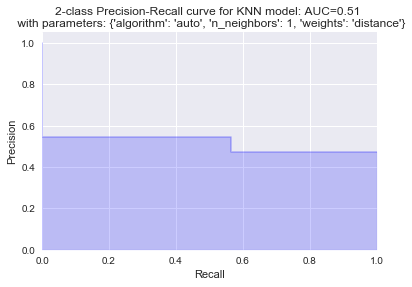

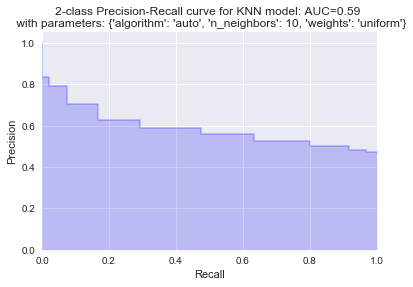

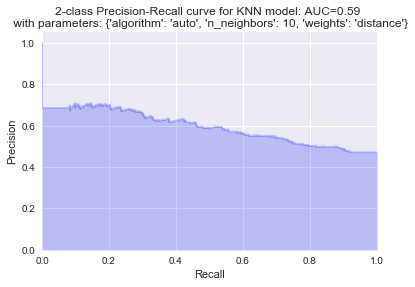

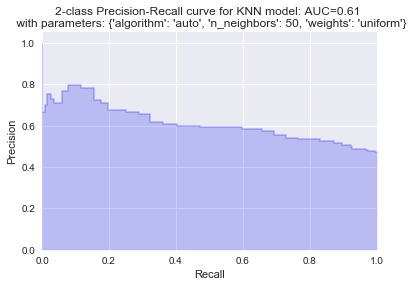

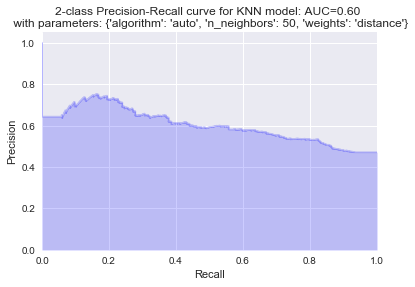

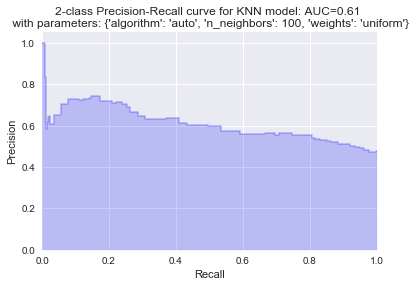

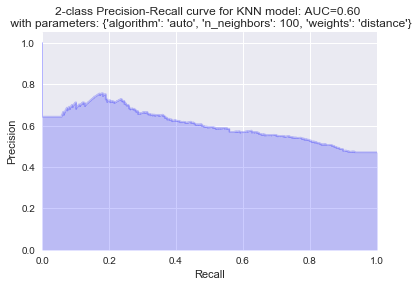

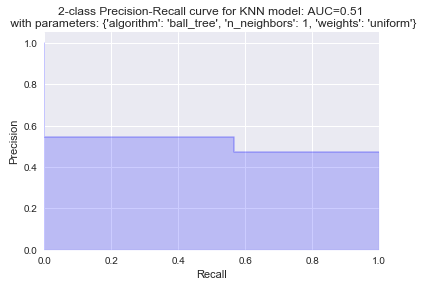

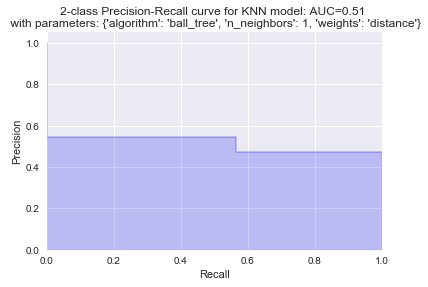

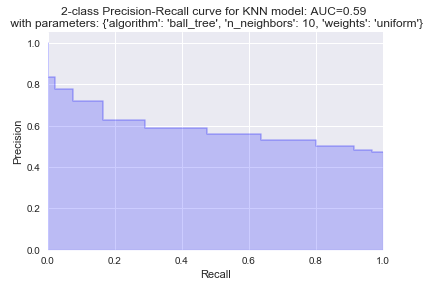

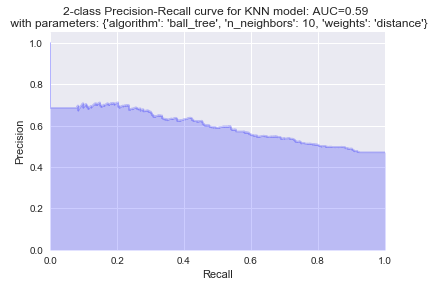

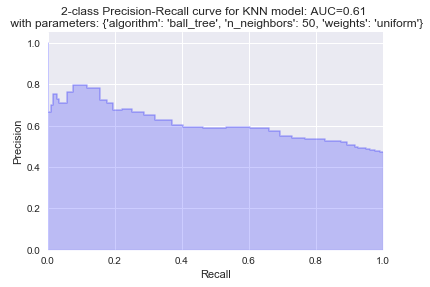

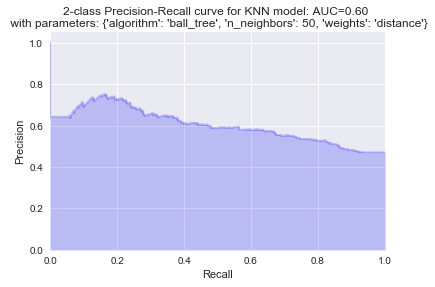

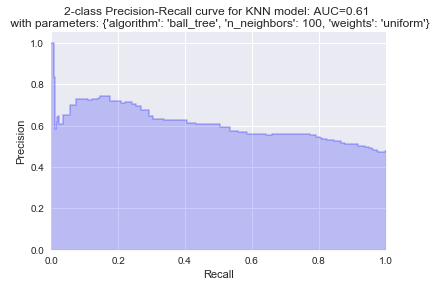

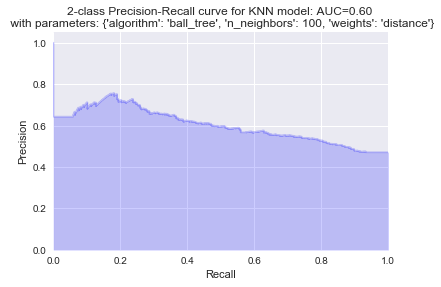

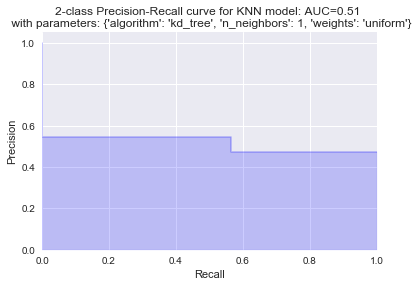

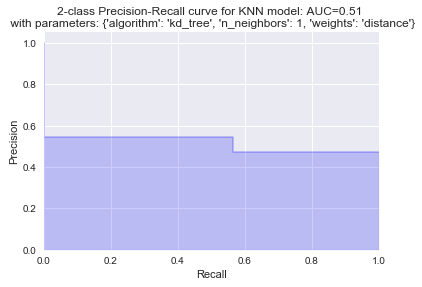

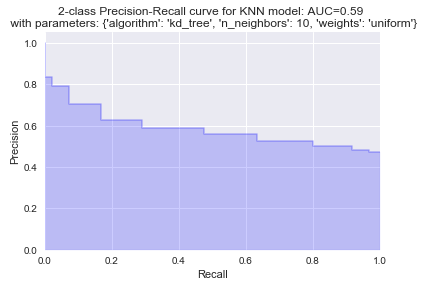

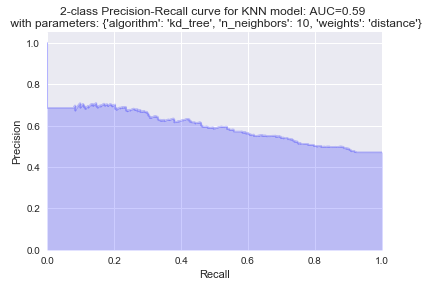

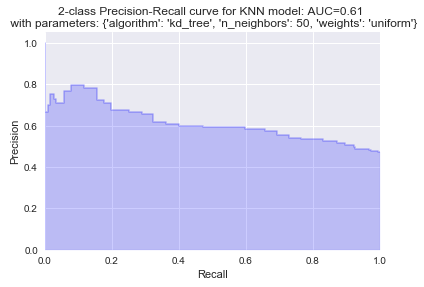

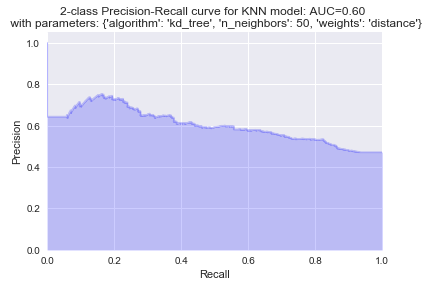

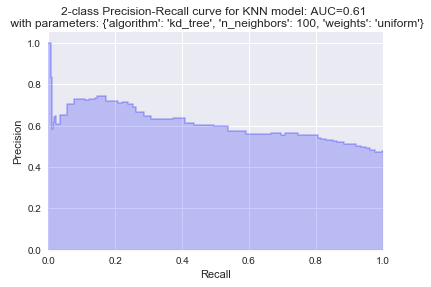

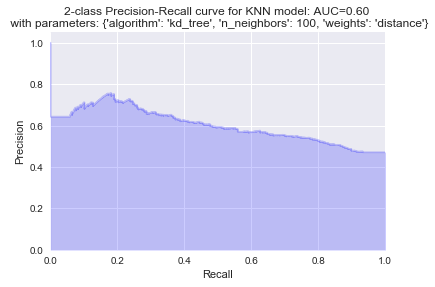

In [11]:
results = clf_loop(["RF", "Boost", "Bag", "Logit", "Tree", "KNN"], x_train, x_test, y_train, y_test)

In [12]:
display(results)

,model_type,parameters,accuracy,auc-roc,auc-pr,time,"precision,recall,f1 at_5","precision,recall,f1 at_10","precision,recall,f1 at_20"
0,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.630722,0.670601,0.641434,0.044485,"(0.7959183673469388, 0.08423326133909287, 0.15...","(0.7755102040816326, 0.16414686825053995, 0.27...","(0.7040816326530612, 0.2980561555075594, 0.418..."
1,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.634791,0.691641,0.662896,0.323961,"(0.8163265306122449, 0.08639308855291576, 0.15...","(0.7755102040816326, 0.16414686825053995, 0.27...","(0.7244897959183674, 0.30669546436285094, 0.43..."
2,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.621567,0.662824,0.641898,0.038776,"(0.7551020408163265, 0.07991360691144708, 0.14...","(0.7755102040816326, 0.16414686825053995, 0.27...","(0.7091836734693877, 0.3002159827213823, 0.421..."
3,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.640895,0.694119,0.663397,0.478003,"(0.6938775510204082, 0.0734341252699784, 0.132...","(0.7857142857142857, 0.16630669546436286, 0.27...","(0.7142857142857143, 0.3023758099352052, 0.424..."
4,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.637843,0.689890,0.650368,0.044236,"(0.7551020408163265, 0.07991360691144708, 0.14...","(0.7448979591836735, 0.15766738660907129, 0.26...","(0.7091836734693877, 0.3002159827213823, 0.421..."
5,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.641913,0.692245,0.665156,0.328409,"(0.7551020408163265, 0.07991360691144708, 0.14...","(0.7959183673469388, 0.16846652267818574, 0.27...","(0.7295918367346939, 0.30885529157667385, 0.43..."
6,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.635809,0.688775,0.654479,0.039927,"(0.8163265306122449, 0.08639308855291576, 0.15...","(0.7959183673469388, 0.16846652267818574, 0.27...","(0.7040816326530612, 0.2980561555075594, 0.418..."
7,RF,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.636826,0.689307,0.663945,0.316375,"(0.8163265306122449, 0.08639308855291576, 0.15...","(0.7959183673469388, 0.16846652267818574, 0.27...","(0.7397959183673469, 0.31317494600431967, 0.44..."
8,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.595117,0.640976,0.611666,0.092571,"(1.0, 0.10583153347732181, 0.19140624999999997)","(0.8877551020408163, 0.1879049676025918, 0.310...","(0.7346938775510204, 0.31101511879049676, 0.43..."
9,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.609359,0.662166,0.652027,0.844896,"(0.9183673469387755, 0.09719222462203024, 0.17...","(0.8163265306122449, 0.17278617710583152, 0.28...","(0.6938775510204082, 0.2937365010799136, 0.412..."


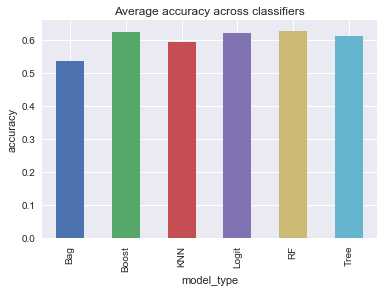

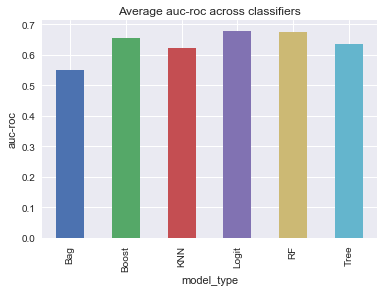

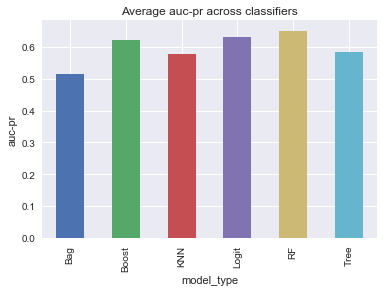

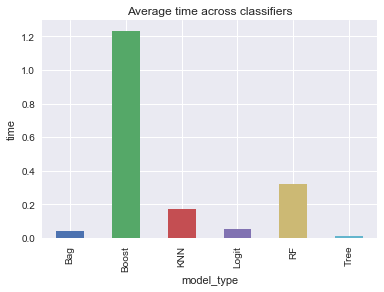

In [13]:
for item in ['accuracy', 'auc-roc','auc-pr','time']:
    plt.figure()
    results.groupby(['model_type'])[item].mean().plot(kind='bar', title='Average '+item+' across classifiers')
    plt.ylabel(item)

In [14]:
results.groupby('model_type')['auc-roc'].nlargest(1)

model_type    
Bag         31    0.629804
Boost       23    0.680620
KNN         86    0.653242
Logit       44    0.688902
RF          3     0.694119
Tree        71    0.683099
Name: auc-roc, dtype: float64

In [16]:
results.loc[[31, 23, 86, 44, 3, 71]].iloc[:,0:6]

,model_type,parameters,accuracy,auc-roc,auc-pr,time
31,Bag,"{'max_features': 5, 'max_samples': 10, 'n_esti...",0.586979,0.629804,0.592688,0.085213
23,Boost,"{'algorithm': 'SAMME.R', 'n_estimators': 1000}",0.618515,0.680620,0.664972,4.681926
86,KNN,"{'algorithm': 'auto', 'n_neighbors': 50, 'weig...",0.608342,0.653242,0.610895,0.152018
44,Logit,"{'C': 0.1, 'penalty': 'l1'}",0.628688,0.688902,0.643397,0.053508
3,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.640895,0.694119,0.663397,0.478003
71,Tree,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.646999,0.683099,0.639760,0.006145
